# "Pump it Up: Data Mining the Water Table"

EDA

Jason & Tom

In [19]:
# Imports

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# EDA

This notebook explains the steps we took while performing EDA on our cleaned dataset

We both took different steps to do this, and collated our findings at the end. Cells by one author only will contain ``` Written By [Author] ``` at the top. Cells without this tag were steps taken by both of us, unless specified.

In [20]:
df = pd.read_csv("./datasets/cleaned_water.csv")

# 1 Graphing

### 1.1 Correlation Matrix

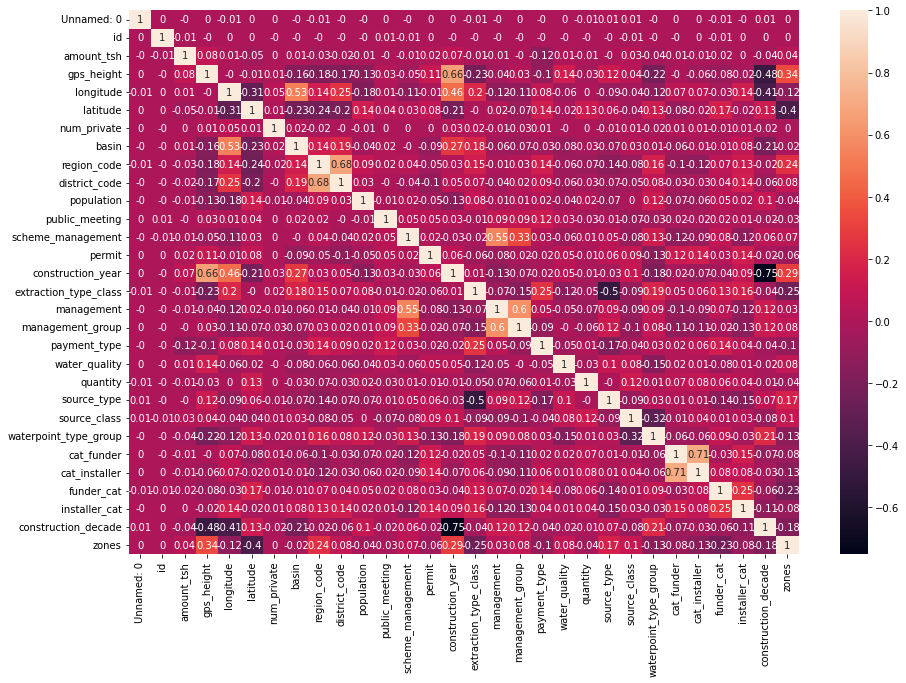

In [21]:
# Author [Jason]

# Correlation Matrix
plt.figure(figsize=(15,10))
features = df.drop(columns = ['outcome'])
matrix = features.corr().round(2)
sns.heatmap(matrix, annot=True)
plt.show()

# 2 Feature Importance

## 2.1 Random Forest

We should test the importance before we drop, but for now it works.

In [22]:
df_test = df.drop(columns = ['id','date_recorded', 'wpt_name','num_private','subvillage','region_code','district_code','lga','ward','recorded_by',
                                      'scheme_name','extraction_type','extraction_type_group','payment','quality_group','quantity_group',
                                      'source','waterpoint_type','status_group','construction_year','region','funder','installer', 'geometry'])

In [24]:
# Author [Jason]

target = df_test.iloc[:,-1]
features = df_test.drop(columns=['outcome'])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier()

Text(0.5, 0, 'Random Forest Feature Importance')

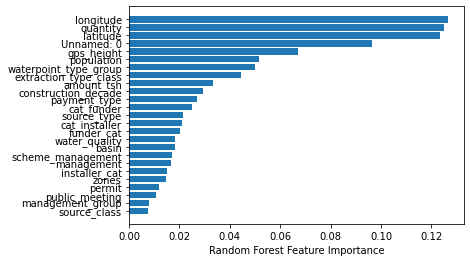

In [25]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(features.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")